<a href="https://colab.research.google.com/github/santhoshs2004/miniproject/blob/main/miniproject_har.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.metrics
from tensorflow.keras.utils import plot_model

In [2]:
label_to_class = {
    1  : 'WALKING',
    2  : 'WALKING_UPSTAIRS',
    3  : 'WALKING_DOWNSTAIRS',
    4  : 'SITTING',
    5  : 'STANDING',
    6  : 'LAYING',
    7  : 'STAND_TO_SIT',
    8  : 'SIT_TO_STAND',
    9  : 'SIT_TO_LIE',
    10 : 'LIE_TO_SIT',
    11 : 'STAND_TO_LIE',
    12 : 'LIE_TO_STAND',
    np.nan : np.nan
}


In [3]:
class_to_label = {
    'WALKING' : 1,
    'WALKING_UPSTAIRS' : 2,
    'WALKING_DOWNSTAIRS' : 3,
    'SITTING' : 4,
    'STANDING' : 5,
    'LAYING' : 6,
    'STAND_TO_SIT' : 7,
    'SIT_TO_STAND' : 8,
    'SIT_TO_LIE' : 9,
    'LIE_TO_SIT' : 10,
    'STAND_TO_LIE' : 11,
    'LIE_TO_STAND' : 12,
    np.nan : np.nan
}

In [4]:
def draw_bar(ydata):
    print('Frequencies :- ',ydata.sum(axis = 0))

    x = np.arange(1,len(ydata[0])+1,1);
    y = ydata.sum(axis = 0)

    plt.figure(figsize = (12.8,3))
    plt.xlabel('Class Label',fontdict = {'size' : 15})
    plt.ylabel('Frequency',fontdict = {'size' : 15})
    bar = plt.bar(x,y)

    for idx,rect in enumerate(bar):
        plt.text(
            rect.get_x()+rect.get_width()/2.0,
            rect.get_height(),int(y[idx]),
            ha = 'center',
            va = 'bottom'
        )

    plt.show()

In [5]:
def draw_wave(xdata,ydata,activity_label):

    row = 0
    while(ydata[row].argmax()+1 != activity_label) : row = row + 1;

    length   = xdata.shape[1]
    sensor   = xdata.shape[2]
    channel  = xdata.shape[3]

    x = np.linspace(0,(20)*(length-1)/1000,length)

    plt.figure(figsize = (12.8,2))
    plt.plot(x,xdata[row,:,0,0])
    plt.plot(x,xdata[row,:,0,1])
    plt.plot(x,xdata[row,:,0,2])
    plt.show()

    plt.figure(figsize = (12.8,2))
    plt.plot(x,xdata[row,:,1,0])
    plt.plot(x,xdata[row,:,1,1])
    plt.plot(x,xdata[row,:,1,2])
    plt.xlabel('Time in seconds :- ( Instance of ' + label_to_class[activity_label] + ' data )',fontdict = {'size' : 15})
    plt.show()

In [6]:
def remove_null(xdata,ydata):
    xdata = xdata[np.where(np.isfinite(ydata))]
    ydata = ydata[np.where(np.isfinite(ydata))]
    ydata = ydata[np.where(np.isfinite(xdata).all(axis = 1).all(axis = 1).all(axis = 1))]
    xdata = xdata[np.where(np.isfinite(xdata).all(axis = 1).all(axis = 1).all(axis = 1))]

    return xdata,ydata

In [7]:
def get_scaler(xdata):

    row = xdata.shape[0]
    timestamp = xdata.shape[1]
    sensor = xdata.shape[2]
    axis = xdata.shape[3]

    scaler = MinMaxScaler(feature_range = (-1,1))
    xdata = xdata.reshape(row,timestamp,sensor*axis)
    xdata = np.swapaxes(xdata,0,2).reshape(sensor*axis,-1).T
    scaler.fit(xdata)
    return scaler


In [8]:
def scale_data(xdata,scaler):

    row = xdata.shape[0]
    timestamp = xdata.shape[1]
    sensor = xdata.shape[2]
    axis = xdata.shape[3]

    xdata = xdata.reshape(row,timestamp,sensor*axis)
    xdata = np.swapaxes(xdata,0,2).reshape(sensor*axis,-1).T
    xdata = scaler.transform(xdata)
    xdata = xdata.T.reshape(sensor*axis,timestamp,row)
    xdata = np.swapaxes(xdata,0,2).reshape(row,timestamp,sensor,axis)

    return xdata

In [9]:
def create_windows(location, exp, user, start, end, activity, length, overlap):

    acc_file  = location + '/acc_exp'+ str(exp).zfill(2) + '_user' + str(user).zfill(2) + '.txt'
    gyro_file = location + '/gyro_exp'+ str(exp).zfill(2) + '_user' + str(user).zfill(2) + '.txt'

    acc_data  = np.loadtxt(acc_file)
    gyro_data = np.loadtxt(gyro_file)

    xtrain = []
    ytrain = []

    while (start + length <= end) :

        stop = start + length
        window = []

        while start != stop :
            window.append( [acc_data[start] , gyro_data[start]] )
            start += 1

        xtrain.append(window)
        ytrain.append(activity)

        start = stop - overlap[activity-1]

    return xtrain,ytrain

In [10]:
def prepare_data(location,length = 128,overlap = [64]*12):

    xdata = []
    ydata = []

    labels = np.loadtxt(location+'/labels.txt',dtype = 'uint32')

    for exp,user,activity,start,end in labels :

        xtemp , ytemp = create_windows(location, exp, user, start, end+1, activity, length, overlap)
        xdata.extend(xtemp)
        ydata.extend(ytemp)

    return np.array(xdata),np.array(ydata)

In [11]:
def to_categorical(ydata):

    for i in range(len(ydata)):
        j = ydata[i].argmax()
        for k in range(len(ydata[i])):
            ydata[i][k] = (k == j)
    return ydata

In [12]:
def one_hot_encoded(ydata):
    ydata = OneHotEncoder().fit_transform(ydata.reshape(len(ydata),1))
    ydata = np.asarray(ydata.todense())
    return ydata

In [13]:
xtrain,ytrain = prepare_data('../content/drive/MyDrive/archive/RawData',128,[64,64,64,64,64,64,120,120,120,120,120,120])

In [14]:
xtrain,ytrain = remove_null(xtrain,ytrain)

# splitting into training (70%) testing (15%) and validation (15%) set


In [16]:
xtrain,xtest,ytrain,ytest = train_test_split(xtrain,ytrain,test_size = 0.3)
xtest,xval,ytest,yval = train_test_split(xtest,ytest,test_size = 0.5)

In [17]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape,xval.shape,yval.shape

((6548, 128, 2, 3),
 (6548,),
 (1403, 128, 2, 3),
 (1403,),
 (1404, 128, 2, 3),
 (1404,))

In [18]:
scaler = get_scaler(xtrain)
xtrain = scale_data(xtrain,scaler)
xtest  = scale_data(xtest,scaler)
xval   = scale_data(xval,scaler)
ytrain = one_hot_encoded(ytrain)
ytest = one_hot_encoded(ytest)
yval = one_hot_encoded(yval)

In [19]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape,xval.shape,yval.shape

((6548, 128, 2, 3),
 (6548, 12),
 (1403, 128, 2, 3),
 (1403, 12),
 (1404, 128, 2, 3),
 (1404, 12))

vizulaizing distribution


For training data :- 
Frequencies :-  [830. 773. 685. 894. 964. 933. 180.  57. 303. 240. 451. 238.]


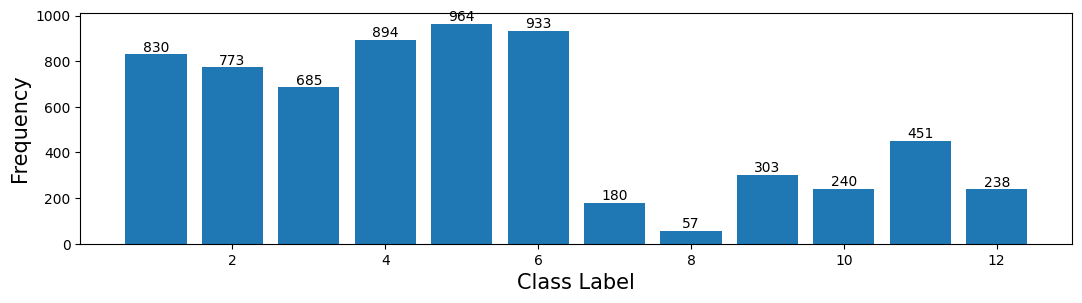

For testing data :- 
Frequencies :-  [169. 166. 150. 176. 210. 215.  40.  11.  65.  60. 103.  38.]


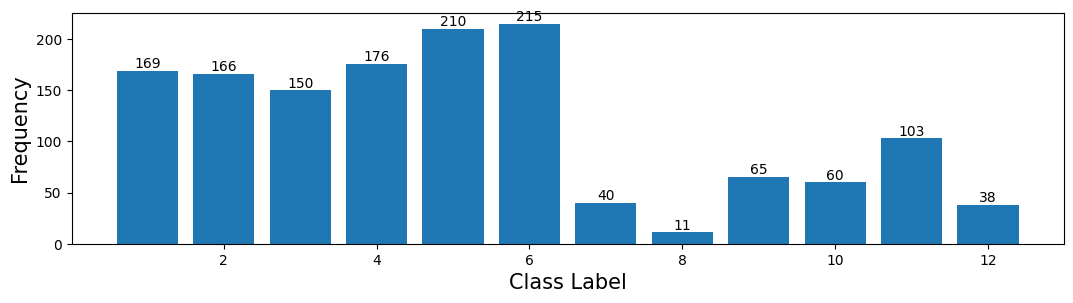

For validation data :- 
Frequencies :-  [189. 163. 144. 181. 210. 216.  39.  12.  68.  50.  87.  45.]


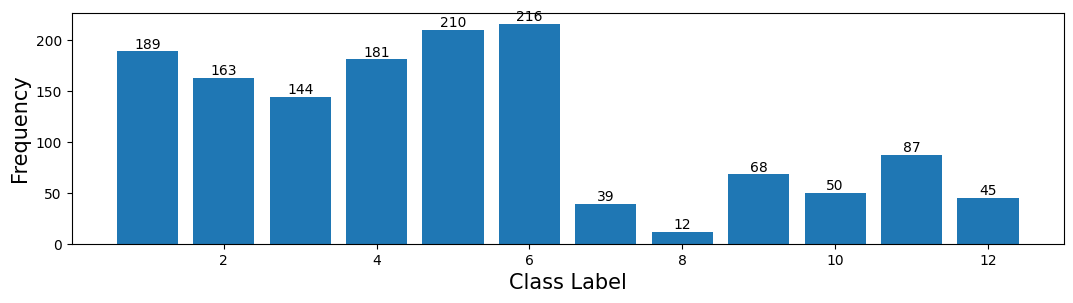

In [20]:
print('For training data :- ')
draw_bar(ytrain)
print('For testing data :- ')
draw_bar(ytest)
print('For validation data :- ')
draw_bar(yval)

Visualizing sensors data for activities

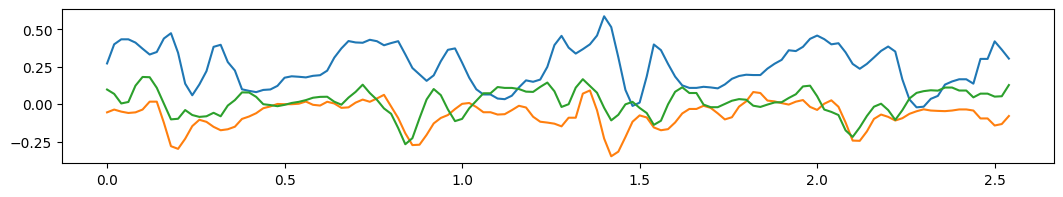

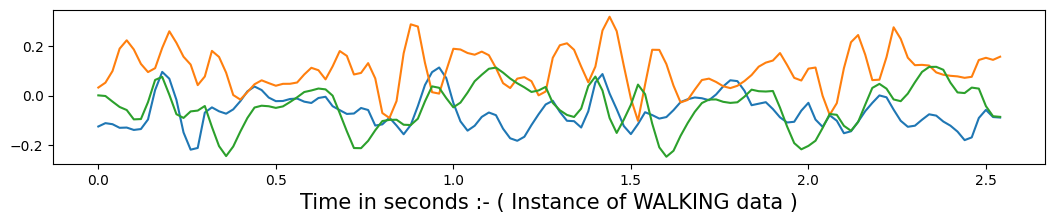

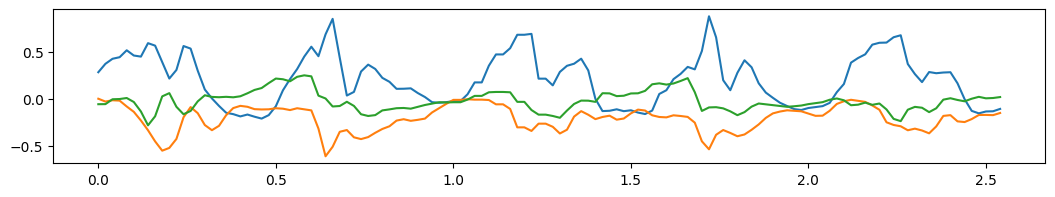

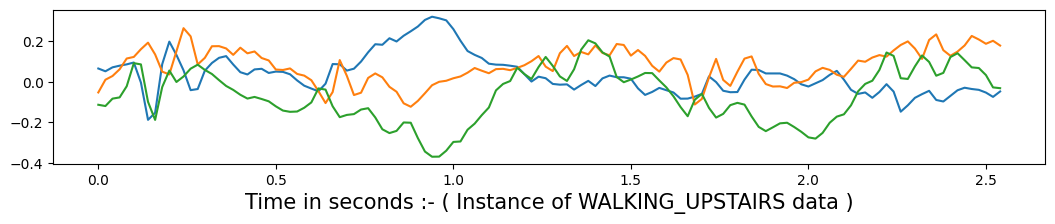

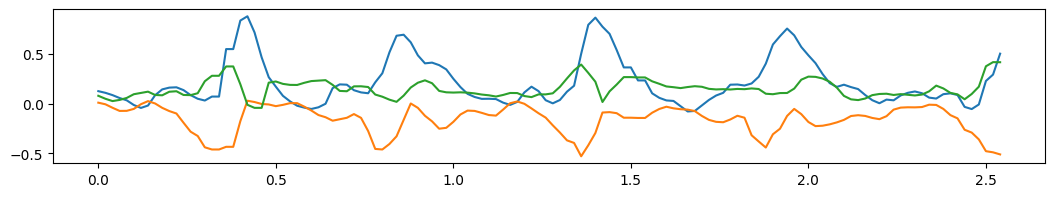

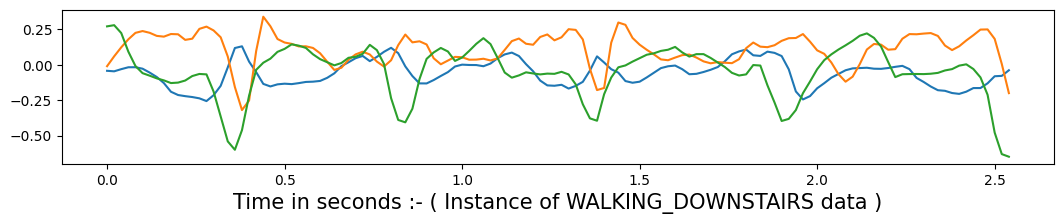

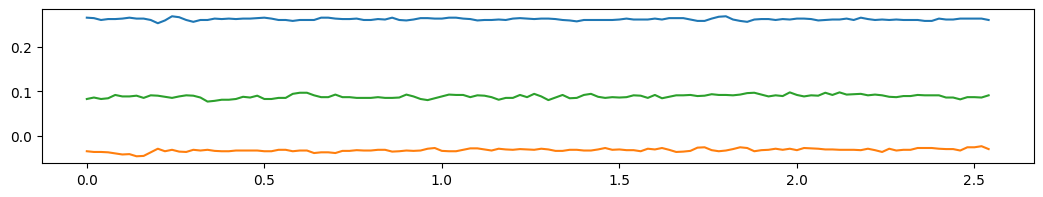

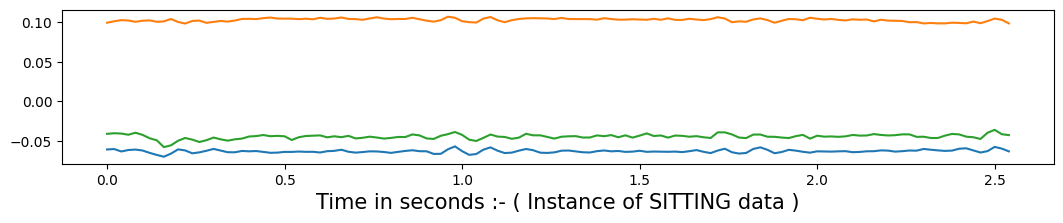

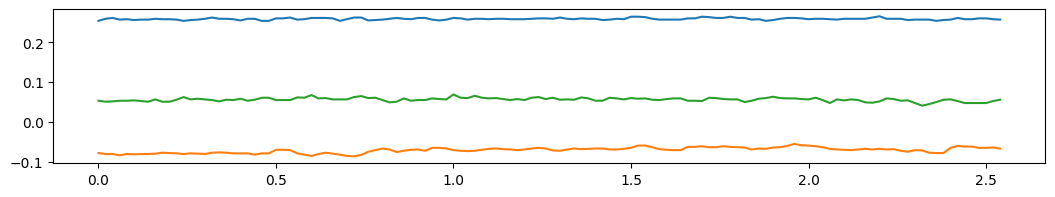

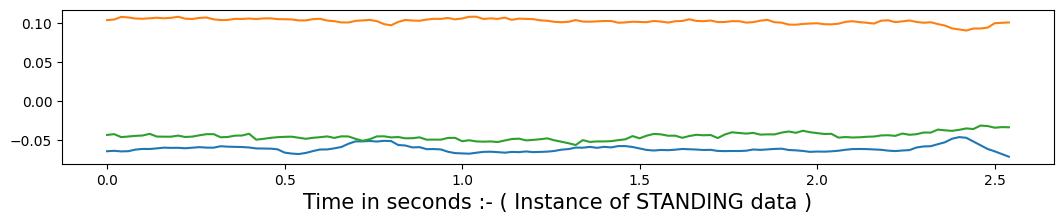

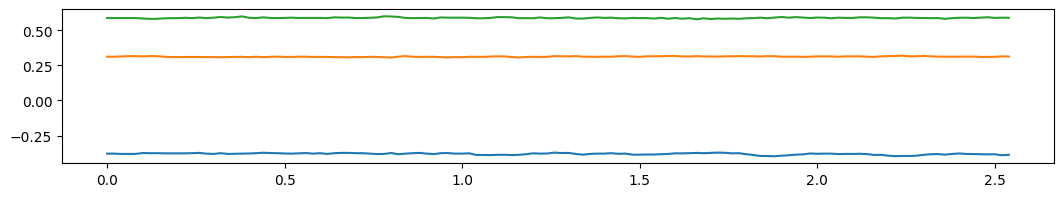

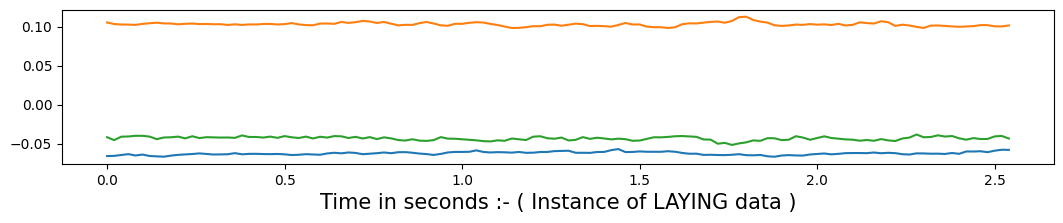

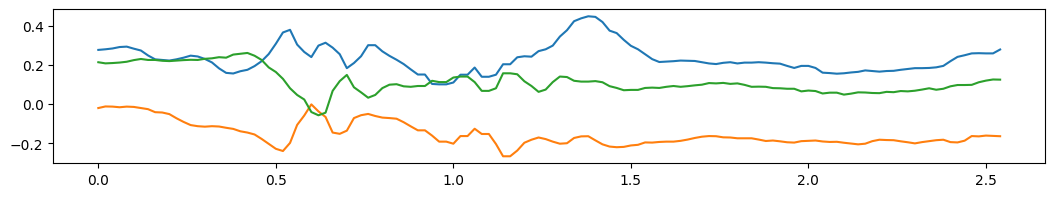

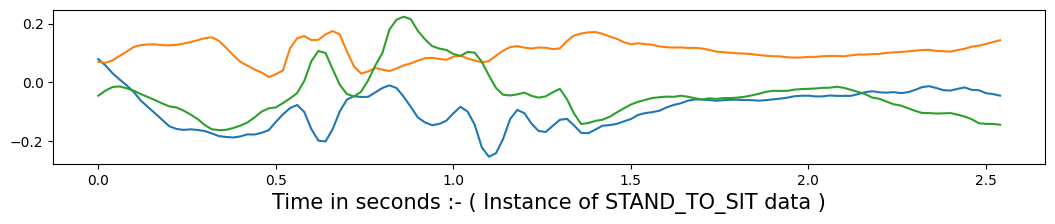

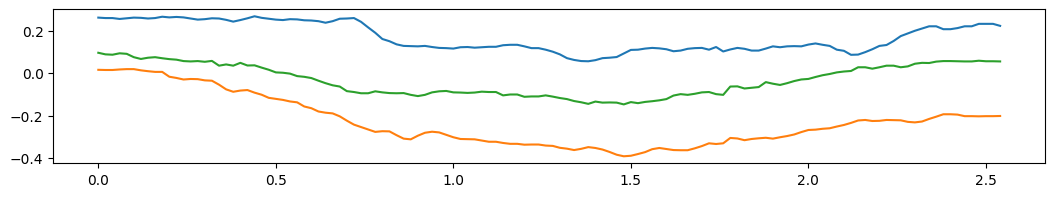

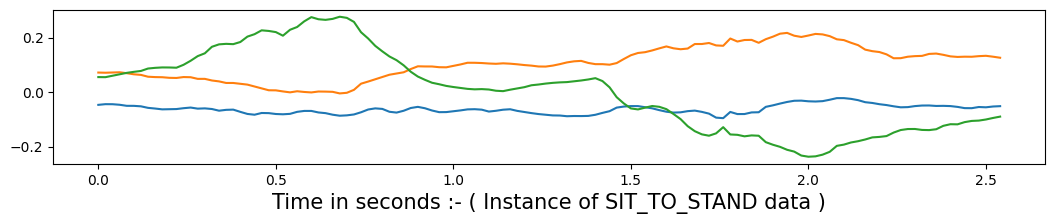

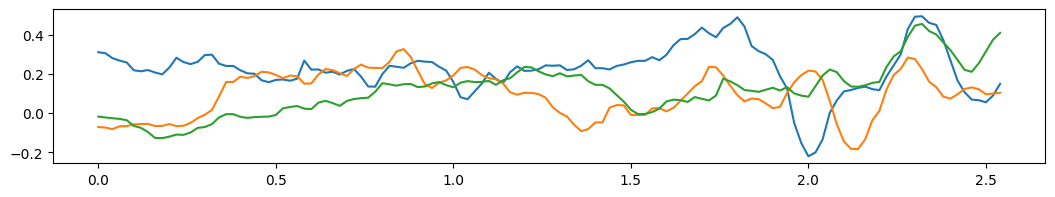

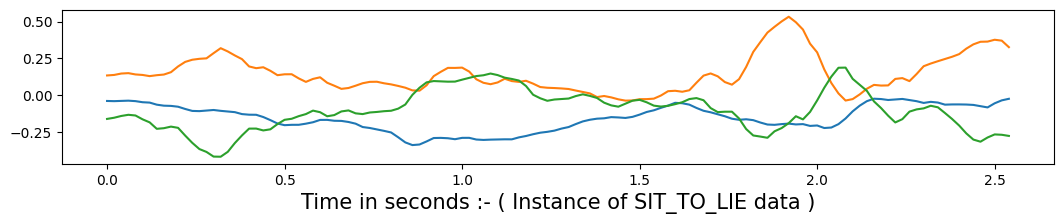

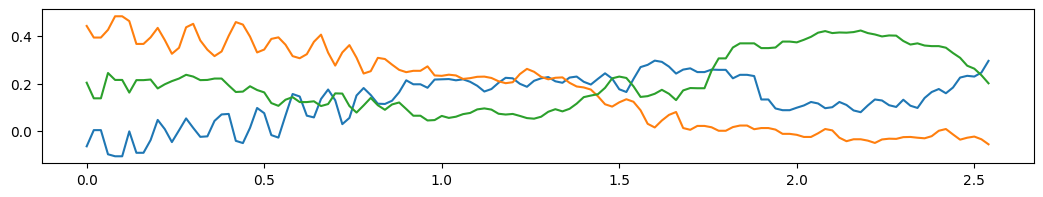

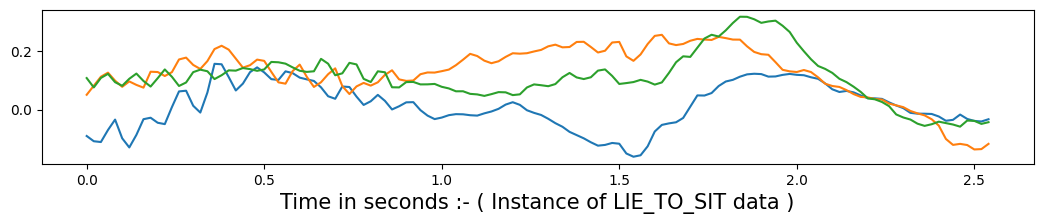

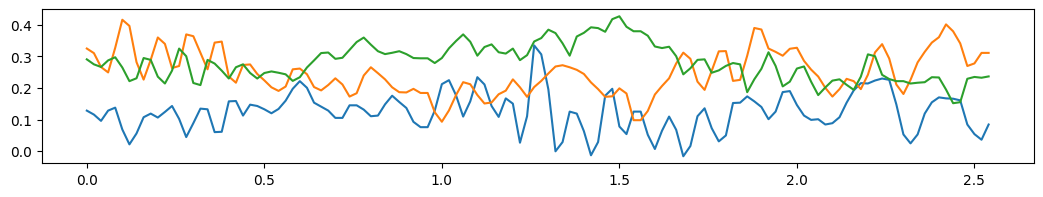

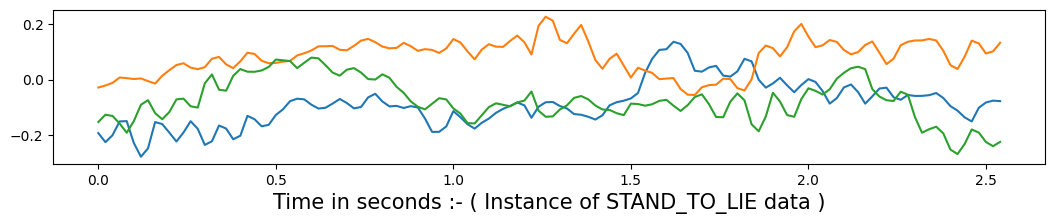

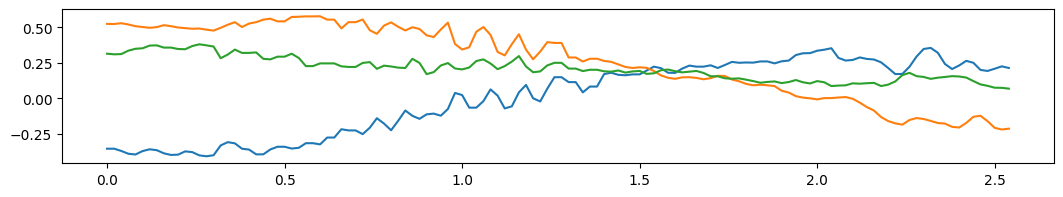

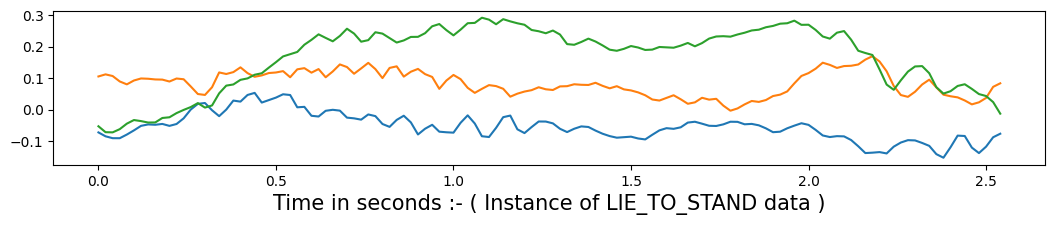

In [21]:
for i in range(12):
    draw_wave(xtrain,ytrain,i+1)

BUILDING THE MODEL

In [23]:
def cnnhead_(input_shape,seq):
    input_layer = keras.Input(shape = input_shape,name = 'title_'+str(seq))

    cnn = layers.Conv1D(24,2,1,"same",name = 'Conv1D_'+str(seq)+'_1')(input_layer)
    cnn = layers.LayerNormalization(name = 'layernorm_'+str(seq)+'_1')(cnn)
    cnn = layers.Dropout(rate = 0.5,name = 'dropout_'+str(seq)+'_1')(cnn)

    cnn = layers.Conv1D(48,2,1,"same",name = 'Conv1D_'+str(seq)+'_2')(cnn)
    cnn = layers.LayerNormalization(name = 'layernorm_'+str(seq)+'_2')(cnn)
    cnn = layers.Dropout(rate = 0.5,name = 'dropout_'+str(seq)+'_2')(cnn)

    cnn = layers.Conv1D(48,2,1,"same",name = 'Conv1D_'+str(seq)+'_3')(cnn)
    cnn = layers.LayerNormalization(name = 'layernorm_'+str(seq)+'_3')(cnn)

    return input_layer,cnn

In [24]:
def concatenate_(heads):
    final_layers = []
    for i,j in heads:
        final_layers.append(j)
    return layers.concatenate(final_layers,name = 'concatenate')

In [25]:
def lstm_(input_, number_of_classes):
    x = layers.LSTM(4*number_of_classes,return_sequences = True,name = 'lstm_1')(input_)
    x = layers.LayerNormalization()(x)
    x = layers.LSTM(4*number_of_classes,return_sequences = True,name = 'lstm_2')(x)
    x = layers.LayerNormalization()(x)
    x = layers.LSTM(2*number_of_classes,name = 'lstm_3')(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(2*number_of_classes,name = 'dense_1')(x)
    x = layers.Dense(number_of_classes,name = 'dense_2',activation = 'softmax')(x)
    return x

In [26]:
def model_(heads,dense_):
    return keras.Model([i for i,j in heads],dense_,name = 'model')

In [27]:
def build_model( xtrain, ytrain ):
    heads = []

    shape = xtrain.shape

    for i in range(len(xtrain[0][0])):
        heads.append(cnnhead_((shape[1],shape[3]),i+1))

    x = concatenate_(heads)

    x = lstm_(x,ytrain.shape[1])

    model = model_(heads,x)

    return model

In [28]:
model = build_model(xtrain,ytrain)

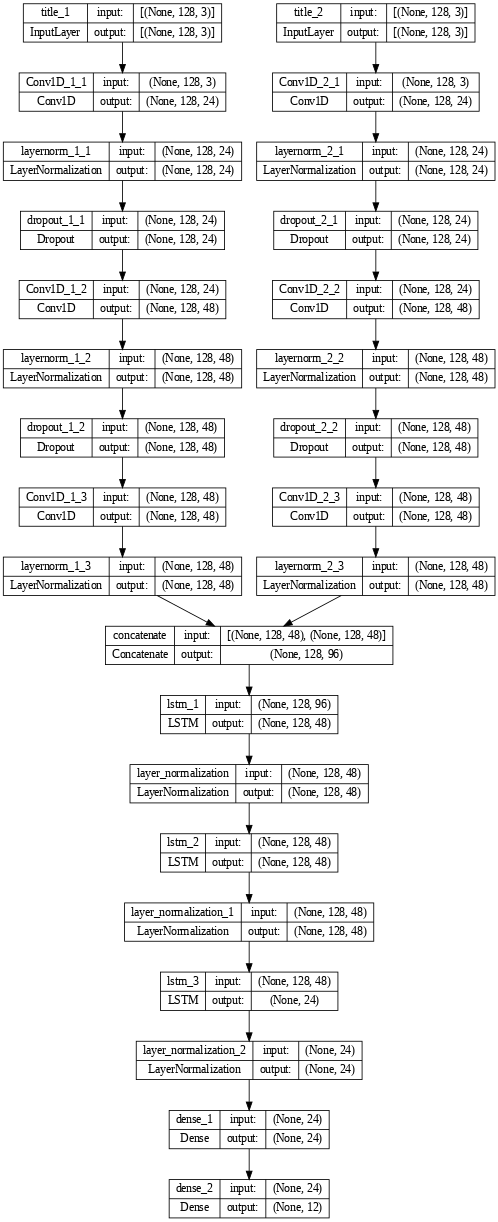

In [29]:
plot_model(model, "multiheaded.png",show_shapes = True,dpi=60)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 title_1 (InputLayer)        [(None, 128, 3)]             0         []                            
                                                                                                  
 title_2 (InputLayer)        [(None, 128, 3)]             0         []                            
                                                                                                  
 Conv1D_1_1 (Conv1D)         (None, 128, 24)              168       ['title_1[0][0]']             
                                                                                                  
 Conv1D_2_1 (Conv1D)         (None, 128, 24)              168       ['title_2[0][0]']             
                                                                                              

TRAINING THE MODEL

In [38]:
!pip install keras
import keras
import time

EPOCHS = 10
BATCH_SIZE = 100

class progress_print(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs = None):
        self.start = time.time()

    def on_epoch_end(self, epoch, logs=None):

        if epoch < 8 or (epoch+1)%10 == 0:
            print(
                'Epoch {}/{} - Time taken : {}s\nloss: {} - accuracy: {} - val_loss: {} - val_accuracy: {}\n'
                .format(epoch+1,EPOCHS,time.time()-self.start,logs['loss'],logs['accuracy'],logs['val_loss'],logs['val_accuracy'])
            )

lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate = 0.001,
decay_steps = int((xtrain.shape[0]+BATCH_SIZE)/BATCH_SIZE),
decay_rate = 0.99
)


model.compile(loss = 'categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate = lr_scheduler),metrics=['accuracy'])

history1 = model.fit(
    {'title_1':xtrain[:,:,0,:],'title_2':xtrain[:,:,1,:],
    },
    {'dense_2':ytrain},
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (
        {'title_1':xval[:,:,0,:],'title_2':xval[:,:,1,:]},
        {'dense_2':yval}
    ),
    verbose = 0,
    callbacks = [progress_print()]
)

Epoch 1/10 - Time taken : 57.44569659233093s
loss: 0.06078864634037018 - accuracy: 0.9773976802825928 - val_loss: 0.09249337017536163 - val_accuracy: 0.9650996923446655

Epoch 2/10 - Time taken : 39.603814125061035s
loss: 0.0595456101000309 - accuracy: 0.9784666895866394 - val_loss: 0.10135458409786224 - val_accuracy: 0.9629629850387573

Epoch 3/10 - Time taken : 39.54083800315857s
loss: 0.051414359360933304 - accuracy: 0.9789248704910278 - val_loss: 0.1229802668094635 - val_accuracy: 0.9608262181282043

Epoch 4/10 - Time taken : 38.53586721420288s
loss: 0.060991235077381134 - accuracy: 0.9780085682868958 - val_loss: 0.08302293717861176 - val_accuracy: 0.9772079586982727

Epoch 5/10 - Time taken : 38.37299346923828s
loss: 0.06775346398353577 - accuracy: 0.9764813780784607 - val_loss: 0.11807279288768768 - val_accuracy: 0.9636752009391785

Epoch 6/10 - Time taken : 38.991087436676025s
loss: 0.06702962517738342 - accuracy: 0.9743432998657227 - val_loss: 0.0735521987080574 - val_accuracy:

visualizing accuracy and losess

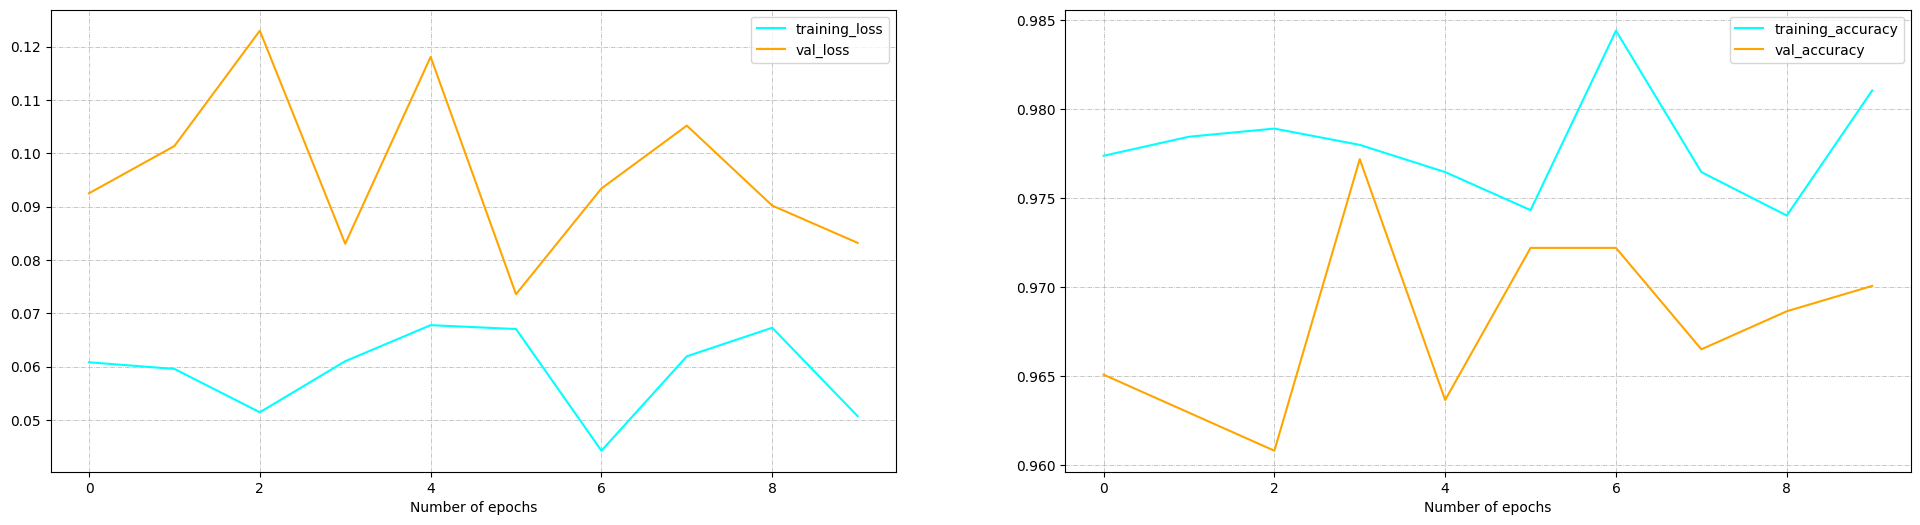

In [43]:
plt.figure(figsize = (24,6))

# Visualizing training_loss and val_loss

plt.subplot(1,2,1)
plt.xlabel('Number of epochs')
plt.grid(True,linewidth = '0.5',linestyle = '-.')
plt.plot(history1.history['loss'],color = 'cyan') #Removed history2 as it is not defined
plt.plot(history1.history['val_loss'],color = 'orange') #Removed history2 as it is not defined
plt.legend(['training_loss','val_loss'])

# Visualizing training_accuracy and val_accuracy

plt.subplot(1,2,2)
plt.xlabel('Number of epochs')
plt.grid(True,linewidth = '0.5',linestyle = '-.')
plt.plot(history1.history['accuracy'],color = 'cyan') #Removed history2 as it is not defined
plt.plot(history1.history['val_accuracy'],color = 'orange') #Removed history2 as it is not defined
plt.legend(['training_accuracy','val_accuracy'])

plt.show()

In [44]:
model.save_weights('trained_weights.h5')
model.load_weights('trained_weights.h5')

In [45]:
ytrain_pred = model.predict(
    {'title_1':xtrain[:,:,0,:],'title_2':xtrain[:,:,1,:],
    }
)
ytest_pred = model.predict(
    {'title_1':xtest[:,:,0,:],'title_2':xtest[:,:,1,:],
    }
)

44/44 [==============================] - 4s 84ms/step


In [46]:
ytrain_pred = to_categorical(ytrain_pred)
ytest_pred = to_categorical(ytest_pred)

<Axes: >

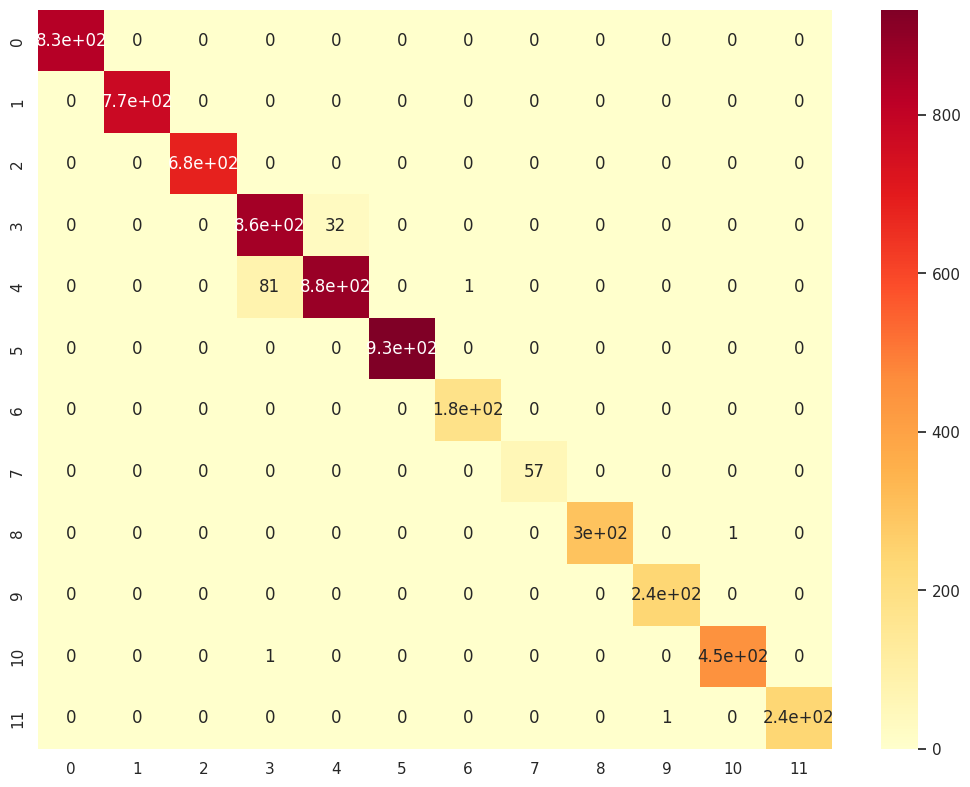

In [47]:
train_cm = confusion_matrix(ytrain.argmax(axis = 1),ytrain_pred.argmax(axis = 1))
test_cm = confusion_matrix(ytest.argmax(axis = 1),ytest_pred.argmax(axis = 1))

sb.set(rc = {'figure.figsize':(12.8,9.6)})
sb.heatmap(train_cm,annot = True,cmap = 'YlOrRd')

<Axes: >

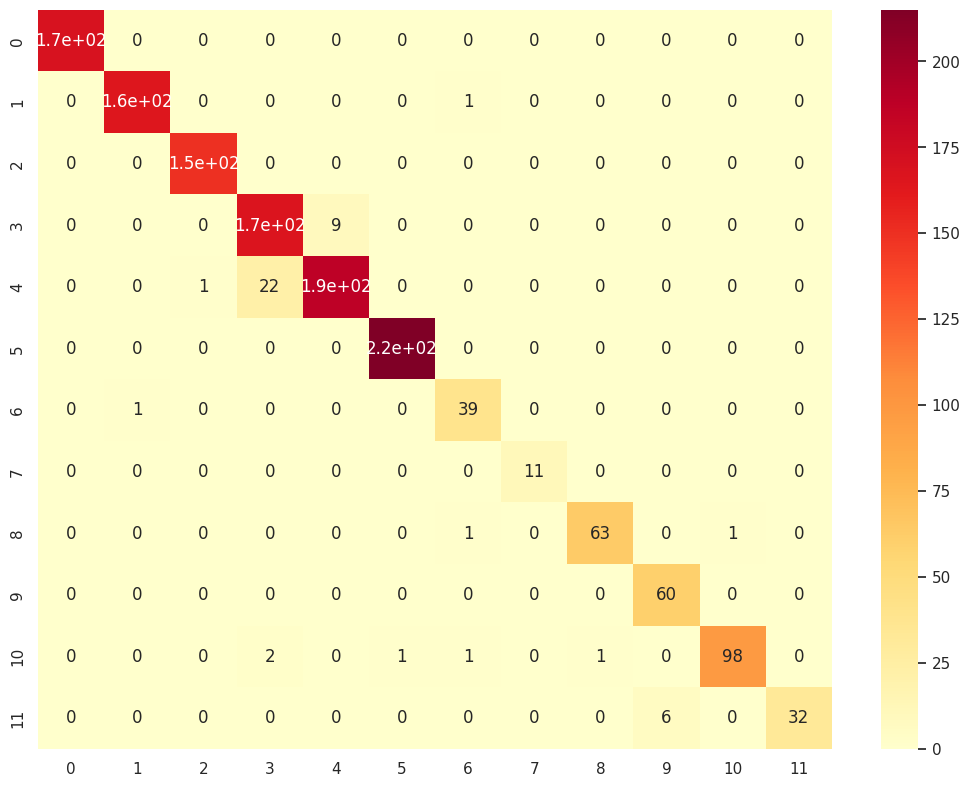

In [48]:
sb.set(rc = {'figure.figsize':(12.8,9.6)})
sb.heatmap(test_cm,annot = True, cmap = 'YlOrRd')

In [49]:
print(sklearn.metrics.classification_report(ytest.argmax(axis = 1),ytest_pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       169
           1       0.99      0.99      0.99       166
           2       0.99      1.00      1.00       150
           3       0.87      0.95      0.91       176
           4       0.95      0.89      0.92       210
           5       1.00      1.00      1.00       215
           6       0.93      0.97      0.95        40
           7       1.00      1.00      1.00        11
           8       0.98      0.97      0.98        65
           9       0.91      1.00      0.95        60
          10       0.99      0.95      0.97       103
          11       1.00      0.84      0.91        38

    accuracy                           0.97      1403
   macro avg       0.97      0.96      0.97      1403
weighted avg       0.97      0.97      0.97      1403



In [50]:
model.save('saved_model/model')

In [51]:
with open('saved_model/scaler','wb') as f:
    pickle.dump(scaler,f)

In [55]:
# To load model and scaler
model = keras.models.load_model('saved_model/model') # Changed 'saved_Model' to 'saved_model'

with open('saved_model/scaler','rb') as f:
    scaler = pickle.load(f)
    #scaler = pickle.load(f) # Removed duplicate line